In [40]:
import openai
from openai import OpenAI
import os
import base64
import requests
from key import OPENAI_API_KEY
import math
import numpy as np
from datetime import timedelta

In [23]:
# Initialize client
api_key=OPENAI_API_KEY
client = OpenAI(api_key=api_key)

In [24]:
# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def list_files(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:  
            file_list.append(os.path.join(root, file))
    return file_list

# Get url name
from video import extract_youtube_id
url = extract_youtube_id("https://www.youtube.com/watch?v=hFkJJkFIA2I")

# Get all the image paths
directory = './frames/' + url  # When you run video.py, all the frames located inside frames folder
image_paths = list_files(directory)

In [25]:
directory

'./frames/hFkJJkFIA2I'

In [26]:
# Get System Prompt
f = open("prompt.txt", "r")
prompt_text = f.read()

# Get User Input
user_input = "great moments"

In [27]:
# results = []

# # Iterate through each image path
# for image_path in image_paths:
#     # Getting the base64 string
#     base64_image = encode_image(image_path)

#     headers = {
#         "Content-Type": "application/json",
#         "Authorization": f"Bearer {api_key}"
#     }

#     payload = {
#         "model": "gpt-4o",
#         "messages": [
#             {"role": "system", "content": prompt_text},
#             {"role": "user", "content": [{"type": "text", "text": user_input}, {"type": "image_url","image_url": {"url": f"data:image/jpg;base64,{base64_image}", "detail": "low"}}]}
#             # user_input text can be removed
#         ],
#         "max_tokens": 4096
#     }

#     # Make the API request
#     response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

#     # Append the result to the list
#     results.append(response.json())

In [28]:
# import concurrent.futures
# import base64
# import requests

# def make_api_request(image_path, api_key, prompt_text, user_input):
#     base64_image = encode_image(image_path)

#     headers = {
#         "Content-Type": "application/json",
#         "Authorization": f"Bearer {api_key}"
#     }

#     payload = {
#         "model": "gpt-4o",
#         "messages": [
#             {"role": "system", "content": prompt_text},
#             {"role": "user", "content": [
#                 {"type": "text", "text": user_input},
#                 {"type": "image_url", "image_url": {"url": f"data:image/jpg;base64,{base64_image}", "detail": "low"}}
#             ]}
#         ],
#         "max_tokens": 4096
#     }

#     response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
#     return response.json()

# def process_images_in_parallel(image_paths, api_key, prompt_text, user_input, num_threads=10):
#     results = []
#     with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
#         future_to_image = {executor.submit(make_api_request, image_path, api_key, prompt_text, user_input): image_path for image_path in image_paths}
#         for future in concurrent.futures.as_completed(future_to_image):
#             image_path = future_to_image[future]
#             try:
#                 result = future.result()
#                 results.append(result)
#             except Exception as exc:
#                 print(f'{image_path} generated an exception: {exc}')

#     return results

# results = process_images_in_parallel(image_paths, api_key, prompt_text, user_input, num_threads=10)
# print(results)

In [29]:
import concurrent.futures
import base64
import requests

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def make_api_request(image_paths, api_key, prompt_text, user_input):
    # Encode all images in the list
    base64_images = [encode_image(image_path) for image_path in image_paths]

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }

    # Prepare the images for the payload
    images_payload = [{"type": "image_url", "image_url": {"url": f"data:image/jpg;base64,{img}", "detail": "low"}} for img in base64_images]

    payload = {
        "model": "gpt-4o",
        "messages": [
            {"role": "system", "content": prompt_text},
            {"role": "user", "content": [
                {"type": "text", "text": user_input},
                *images_payload
            ]}
        ],
        "max_tokens": 1600
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    return response.json()

def process_images_in_parallel(image_paths, api_key, prompt_text, user_input, num_threads=10, frames_per_request=3):
    results = []

    # Split image_paths into chunks of frames_per_request
    image_chunks = [image_paths[i:i + frames_per_request] for i in range(0, len(image_paths), frames_per_request)]

    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        future_to_image_chunk = {executor.submit(make_api_request, chunk, api_key, prompt_text, user_input): chunk for chunk in image_chunks}
        for future in concurrent.futures.as_completed(future_to_image_chunk):
            image_chunk = future_to_image_chunk[future]
            try:
                result = future.result()
                results.append(result)
            except Exception as exc:
                print(f'{image_chunk} generated an exception: {exc}')

    return results

results = process_images_in_parallel(image_paths, api_key, prompt_text, user_input, num_threads=30, frames_per_request=3)
print(results)

[{'id': 'chatcmpl-9gynjqhHcYm1H9Y8PJI2CgBhpqYLT', 'object': 'chat.completion', 'created': 1720030523, 'model': 'gpt-4o-2024-05-13', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '### Explanation\n\n- **Main Subjects:** An older woman and a balcony inside a home.\n- **Actions:** The woman is peering over the balcony, waving with a smile, and appears to be engaged with someone or something below.\n- **Context:** The images capture a heartwarming moment within a domestic setting, suggesting a joyful interaction possibly with family or friends from a different level of the house, emphasizing the cozy and loving atmosphere.'}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 1130, 'completion_tokens': 87, 'total_tokens': 1217}, 'system_fingerprint': 'fp_4008e3b719'}, {'id': 'chatcmpl-9gynkrtoY8mK6IOwfqBTZoSOhOwfh', 'object': 'chat.completion', 'created': 1720030524, 'model': 'gpt-4o-2024-05-13', 'choices': [{'index': 0, 'message': {'role': 'assi

In [30]:
# Result Sample
results[0]

{'id': 'chatcmpl-9gynjqhHcYm1H9Y8PJI2CgBhpqYLT',
 'object': 'chat.completion',
 'created': 1720030523,
 'model': 'gpt-4o-2024-05-13',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': '### Explanation\n\n- **Main Subjects:** An older woman and a balcony inside a home.\n- **Actions:** The woman is peering over the balcony, waving with a smile, and appears to be engaged with someone or something below.\n- **Context:** The images capture a heartwarming moment within a domestic setting, suggesting a joyful interaction possibly with family or friends from a different level of the house, emphasizing the cozy and loving atmosphere.'},
   'logprobs': None,
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 1130,
  'completion_tokens': 87,
  'total_tokens': 1217},
 'system_fingerprint': 'fp_4008e3b719'}

In [45]:
# Iterate through all the results
missing_count = 0
missing_list = list()
captions_dict = {}

def seconds_to_hhmmss(seconds):
    return str(timedelta(seconds=seconds))

captions_dict = {}


for i in range(len(results)):
    try:
        caption = results[i]['choices'][0]['message']['content']
        start_time = i * 5   # Time interval (5 seconds)
        captions_dict[seconds_to_hhmmss(start_time)] = caption
        print(i, ": ", caption)
        
    except KeyError:
        print(i, ": missing")
        captions_dict[seconds_to_hhmmss(i*5)] = "Missing"
        missing_count += 1
        missing_list.append(i)

print("\nMissing count: ", missing_count, "\nMissing List: ", missing_list)

0 :  ### Explanation

- **Main Subjects:** An older woman and a balcony inside a home.
- **Actions:** The woman is peering over the balcony, waving with a smile, and appears to be engaged with someone or something below.
- **Context:** The images capture a heartwarming moment within a domestic setting, suggesting a joyful interaction possibly with family or friends from a different level of the house, emphasizing the cozy and loving atmosphere.
1 :  ### Explanation

- **Main Subjects:** A person opening a door, a man inside a home, the interior of the house.
- **Actions:** The door is being unlocked and opened, revealing a man inside grinning broadly, followed by a partial view of the interior of the house.
- **Context:** The images capture a significant and joyful moment, potentially marking a surprise visit or reunion. The smile on the man's face highlights the happiness and excitement of the occasion, providing a warm and welcoming atmosphere.
2 :  #### Daily Vlog
- Main Subjects: T

In [97]:
import json 
with open('./results/captions.json', 'w') as file:  
    json.dump(captions_dict, file)

In [56]:
embedding_model = 'text-embedding-3-small'
texts = results

def get_embedding(text, model=embedding_model):
    return client.embeddings.create(input=[text], model=model).data[0].embedding

def process_embeddings_in_parallel(results, model=embedding_model, num_threads=len(results)):
    def embed_result(result):
        return get_embedding(result['choices'][0]['message']['content'], model=model)
    
    embedded_frame = {}

    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        future_to_index = {executor.submit(embed_result, result): i for i, result in enumerate(results)}
        for future in concurrent.futures.as_completed(future_to_index):
            i = future_to_index[future]
            try:
                embedding = future.result()
                embedded_frame[i] = np.array(embedding).reshape(1, -1)
            except Exception as exc:
                print(f'Embedding for result {i} generated an exception: {exc}')

    return embedded_frame

# Usage
embedded_frame = process_embeddings_in_parallel(texts, model=embedding_model, num_threads=len(results))

# Embed the query
embedded_query = get_embedding(user_input, model=embedding_model)
embedded_query = np.array(embedded_query).reshape(1, -1)

print(embedded_frame)
print(embedded_query)

{7: array([[ 0.03952567,  0.02859362, -0.04076171, ...,  0.0047965 ,
        -0.0416956 ,  0.01462642]]), 8: array([[ 0.03420938,  0.01831597, -0.02482505, ...,  0.00906622,
        -0.03063673,  0.00544157]]), 11: array([[ 0.00826108,  0.02011167, -0.03965316, ...,  0.01333435,
        -0.05857264,  0.00461324]]), 1: array([[ 0.03587986,  0.02181461, -0.03786688, ...,  0.01064474,
        -0.02997558,  0.01195759]]), 4: array([[ 0.0551062 ,  0.01513878, -0.01090429, ..., -0.01085289,
        -0.02691054,  0.02574107]]), 3: array([[ 0.03340449,  0.02337427, -0.01707209, ..., -0.01133208,
        -0.03307902,  0.01701292]]), 15: array([[ 0.0148777 , -0.00903498, -0.03449987, ..., -0.01407231,
        -0.02854   ,  0.03408985]]), 9: array([[ 0.01744163,  0.0069844 , -0.01413082, ...,  0.02028752,
        -0.04409718, -0.00620601]]), 2: array([[ 0.03232549,  0.01748163, -0.06263386, ..., -0.00192822,
        -0.04419541,  0.03113591]]), 39: array([[ 0.02554121,  0.03892471, -0.04783037, .

In [59]:
embedded_frame

{7: array([[ 0.03952567,  0.02859362, -0.04076171, ...,  0.0047965 ,
         -0.0416956 ,  0.01462642]]),
 8: array([[ 0.03420938,  0.01831597, -0.02482505, ...,  0.00906622,
         -0.03063673,  0.00544157]]),
 11: array([[ 0.00826108,  0.02011167, -0.03965316, ...,  0.01333435,
         -0.05857264,  0.00461324]]),
 1: array([[ 0.03587986,  0.02181461, -0.03786688, ...,  0.01064474,
         -0.02997558,  0.01195759]]),
 4: array([[ 0.0551062 ,  0.01513878, -0.01090429, ..., -0.01085289,
         -0.02691054,  0.02574107]]),
 3: array([[ 0.03340449,  0.02337427, -0.01707209, ..., -0.01133208,
         -0.03307902,  0.01701292]]),
 15: array([[ 0.0148777 , -0.00903498, -0.03449987, ..., -0.01407231,
         -0.02854   ,  0.03408985]]),
 9: array([[ 0.01744163,  0.0069844 , -0.01413082, ...,  0.02028752,
         -0.04409718, -0.00620601]]),
 2: array([[ 0.03232549,  0.01748163, -0.06263386, ..., -0.00192822,
         -0.04419541,  0.03113591]]),
 39: array([[ 0.02554121,  0.038924

In [33]:
# embedding_model = 'text-embedding-3-small'
# def get_embedding(text, model=embedding_model):
#    return client.embeddings.create(input = [text], model=model).data[0].embedding

# embedded_frame = {}
# for i in range(len(results)):
#     embedded_frame[i] = get_embedding(results[i]['choices'][0]['message']['content'], model=embedding_model)
#     embedded_frame[i] = np.array(embedded_frame[i]).reshape(1,-1)

# embedded_query = get_embedding(user_input, model=embedding_model)
# embedded_query = np.array(embedded_query).reshape(1,-1)

In [74]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_result = {}
for i in range(len(image_paths)//3):
    try:
        similarity_result[seconds_to_hhmmss(i*5)] = cosine_similarity(embedded_frame[i], embedded_query).item()
    except KeyError:
        similarity_result[seconds_to_hhmmss(i*5)] = 0
        
ranked_frame_dict = dict(sorted(similarity_result.items(), key=lambda x:x[1], reverse=True))

In [75]:
ranked_frame_list = list(ranked_frame_dict.keys())
ranked_frame_list[:10]

['0:07:20',
 '0:11:55',
 '0:07:45',
 '0:05:35',
 '0:05:30',
 '0:06:05',
 '0:11:35',
 '0:00:05',
 '0:14:15',
 '0:08:55']

In [78]:
ranked_frame_dict

{'0:07:20': 0.4919062659514394,
 '0:11:55': 0.48920007446230507,
 '0:07:45': 0.3647601578636248,
 '0:05:35': 0.36218396816027926,
 '0:05:30': 0.3608468375403689,
 '0:06:05': 0.3494583165609487,
 '0:11:35': 0.31492164516682786,
 '0:00:05': 0.3116375853399716,
 '0:14:15': 0.304506759254302,
 '0:08:55': 0.30400274826519025,
 '0:12:05': 0.3036602658296767,
 '0:04:05': 0.30297502795399767,
 '0:01:50': 0.2972349737838428,
 '0:02:45': 0.29443523363162155,
 '0:14:25': 0.29117985267978286,
 '0:11:25': 0.2907137324553747,
 '0:03:20': 0.2900588545825491,
 '0:01:25': 0.289816298298897,
 '0:02:10': 0.2895674814340132,
 '0:00:15': 0.2884707549163607,
 '0:08:30': 0.2879038624653049,
 '0:06:50': 0.28704954404839744,
 '0:09:20': 0.2865944997282967,
 '0:01:10': 0.28623092886552576,
 '0:12:40': 0.2843021845480874,
 '0:15:00': 0.2836302260238295,
 '0:13:40': 0.2830748541775129,
 '0:11:30': 0.28252994180472774,
 '0:06:40': 0.2822159061855145,
 '0:03:10': 0.2819517053813825,
 '0:07:00': 0.2819310045261497,


In [86]:
import pandas as pd
df = pd.DataFrame(list(ranked_frame_dict.items()), columns=['Time', 'Value'])
df.head()

,Time,Value
0,0:07:20,0.491906
1,0:11:55,0.489200
2,0:07:45,0.364760
3,0:05:35,0.362184
4,0:05:30,0.360847


In [87]:
df.describe()

,Value
count,181.000000
mean,0.254999
std,0.040513
min,0.172900
25%,0.230695
50%,0.251716
75%,0.273383
max,0.491906


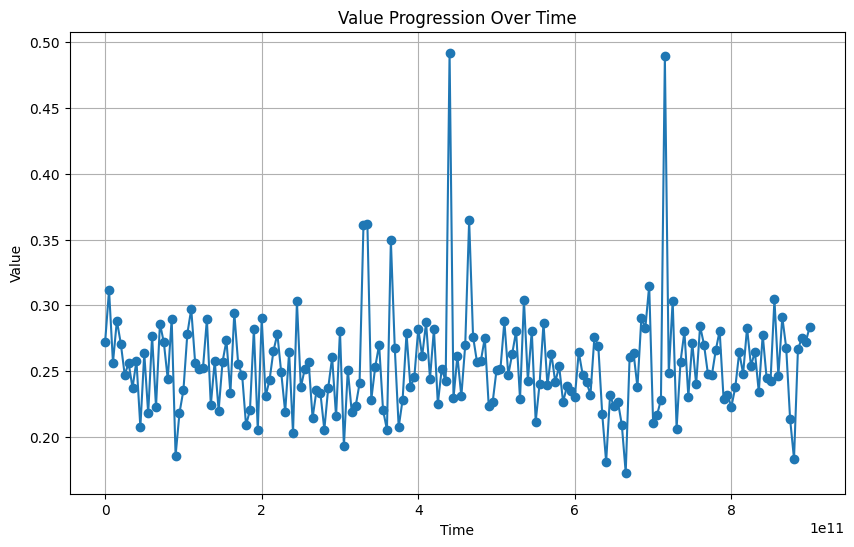

In [88]:
import matplotlib.pyplot as plt
# Convert the 'Time' column to a datetime type for accurate sorting
df['Time'] = pd.to_timedelta(df['Time'])

# Sort the DataFrame by time
df = df.sort_values(by='Time')

# Plot the progression of the values
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Value'], marker='o')
plt.title('Value Progression Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()